In [4]:
from TwitterAPI import TwitterAPI, TwitterPager
import requests_cache
import time
import csv
import pandas as pd
import pickle
import re
import nltk
import nltk.corpus
import numpy as np
from wordcloud import WordCloud, STOPWORDS
from nltk.corpus import wordnet
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from nltk.stem.snowball import SnowballStemmer
plt.rcParams["figure.figsize"] = [10, 8]

# Gathering the Data

In [4]:
consumer_key = "redacted"
consumer_secret = "redacted"
access_token_key = 'redacted'
access_token_secret = 'redacted'

# make the connection
api = TwitterAPI(consumer_key, consumer_secret, access_token_key, access_token_secret)

In [52]:
#https://github.com/geduldig/TwitterAPI/blob/master/examples/premium_search.py
#https://developer.twitter.com/en/docs/tweets/search/api-reference/premium-search
#https://stackoverflow.com/questions/50724765/how-to-retrieve-all-historical-public-tweets-with-twitter-premium-search-api-in

SEARCH_TERM = 'California Camp Fire'
PRODUCT = '30day'
LABEL = '30day'

pager = TwitterPager(api, 'tweets/search/%s/:%s' % (PRODUCT, LABEL),
                     {'query':SEARCH_TERM})

thirty_days = [{
    "Post_date":      item['created_at'],
    "User":           item['user']['screen_name'],
    "Quote_Count":    item['quote_count'],
    "Reply_Count":    item['reply_count'],
    "Retweet_Count":  item['retweet_count'],
    "Favorite_Count": item['favorite_count'],
    "Location":       item['user']['location'],
    "Text":           item['text']
} for item in pager.get_iterator() if 'text' in item]

#csvFile.close()

In [58]:
thirty_days_df = pd.DataFrame(thirty_days)
thirty_days_df

,Favorite_Count,Location,Post_date,Quote_Count,Reply_Count,Retweet_Count,Text,User
0,0,"Abu Dhabi, United Arab Emirates",Wed Mar 06 06:07:34 +0000 2019,0,0,0,RT @cnnbrk: Pacific Gas &amp; Electric says it...,saeed_m_alshams
1,0,"Paso Robles, CA",Wed Mar 06 04:10:04 +0000 2019,0,0,0,RT @Bewickwren: California Wildfires On The Sc...,CalDisasters
2,0,New Mexico USA,Wed Mar 06 04:06:53 +0000 2019,0,0,1,California Wildfires On The Scale Of Camp Fire...,Bewickwren
3,0,Philippines,Wed Mar 06 03:11:18 +0000 2019,0,0,0,California Wildfires On The Scale Of Camp Fire...,iiradned
4,0,"Enterprise, Al",Wed Mar 06 03:05:06 +0000 2019,0,0,0,California Wildfires On The Scale Of Camp Fire...,Kay_Z_18
5,0,Virginia,Wed Mar 06 02:56:53 +0000 2019,0,0,0,RT @AnimalBandon: This is what we just sent to...,Billylittlebit
6,0,"Central Harlem, Manhattan",Wed Mar 06 02:01:43 +0000 2019,0,0,0,RT @cnnbrk: Pacific Gas &amp; Electric says it...,Limeylizzie
7,0,"Antelope, California, USA",Wed Mar 06 02:00:39 +0000 2019,0,0,0,PG&amp;E is risky but I am saying to buy it so...,JamesPup
8,0,NZ . East BOP,Wed Mar 06 02:00:12 +0000 2019,0,0,0,RT @cnnbrk: Pacific Gas &amp; Electric says it...,transparency_a1
9,0,Italia,Wed Mar 06 01:25:29 +0000 2019,0,0,0,RT @usatodayvideo: A dog returns home 101 days...,dtm96_usa


In [59]:
# Save the data
thirty_days_df.to_pickle("thirty_days.txt")

In [303]:
# Reload data if needed
thirty_days_df = pd.read_pickle("thirty_days.txt")

# Cleaning the Data

In [407]:
def wordnet_pos(tag):
    """Map a Brown POS tag to a WordNet POS tag."""
    
    table = {"N": wordnet.NOUN, "V": wordnet.VERB, "R": wordnet.ADV, "J": wordnet.ADJ}
    
    # Default to a noun.
    return table.get(tag[0], wordnet.NOUN)

def corpus_cleaner(text):
    """
    Performs basic corpus cleaning by performing tokenization, lowercasing, removing non-words
    removing stop-words, and lemmatizing. Returns a list of the cleaned text
    
    text: an article dataframe as described in Excercise 1.3
    """
    #Tokenize the words
    words = [nltk.word_tokenize(x) for x in text["text"]]

    #https://stackoverflow.com/questions/952914/how-to-make-a-flat-list-out-of-list-of-lists
    #Flatten the list of lists
    words = [item for sublist in words for item in sublist]

    #lowercase words and remove non-words
    lower = [w.lower() for w in words if (re.search("[0-9:\\.`'“’(),”\-@—&;$#!\*\+\?_/]|\\\\u[0-9]+|https|\\bamp\\b|\\brt\\b", w) is None) and re.search("[a-zA-Z]", w)]

    #Init lemmatizer and stopword dict
    lemmatizer = nltk.WordNetLemmatizer()
    stopwords = nltk.corpus.stopwords.words("english")

    #Lemmatize and remove stopwords
    article_tags = nltk.pos_tag(lower)
    cleaned = [lemmatizer.lemmatize(w, wordnet_pos(t)) for (w, t) in article_tags if w not in stopwords]
    return(cleaned)

In [246]:
cleaned_thirty_days = corpus_cleaner(thirty_days_df)

In [247]:
cleaned_thirty_days

['rt',
 'cnnbrk',
 'pacific',
 'gas',
 'electric',
 'say',
 'probable',
 'equipment',
 'find',
 'ignition',
 'point',
 'last',
 'year',
 'camp',
 'fi…',
 'rt',
 'bewickwren',
 'california',
 'wildfire',
 'scale',
 'camp',
 'fire',
 'could',
 'happen',
 'year',
 'say',
 'proceeding',
 'national',
 'academy',
 'scien…',
 'california',
 'wildfire',
 'scale',
 'camp',
 'fire',
 'could',
 'happen',
 'year',
 'say',
 'proceeding',
 'national',
 'academy…',
 'california',
 'wildfire',
 'scale',
 'camp',
 'fire',
 'could',
 'happen',
 'year',
 'scientist',
 'say',
 'via',
 'iflscience',
 'california',
 'wildfire',
 'scale',
 'camp',
 'fire',
 'could',
 'happen',
 'year',
 'scientist',
 'say',
 'rt',
 'animalbandon',
 'send',
 'concow',
 'butte',
 'county',
 'california',
 'day',
 'camp',
 'fire',
 'november',
 'bandon',
 'an…',
 'rt',
 'cnnbrk',
 'pacific',
 'gas',
 'electric',
 'say',
 'probable',
 'equipment',
 'find',
 'ignition',
 'point',
 'last',
 'year',
 'camp',
 'fi…',
 'pg',
 'e',
 '

# Exploratory Data Analysis

## Word Cloud

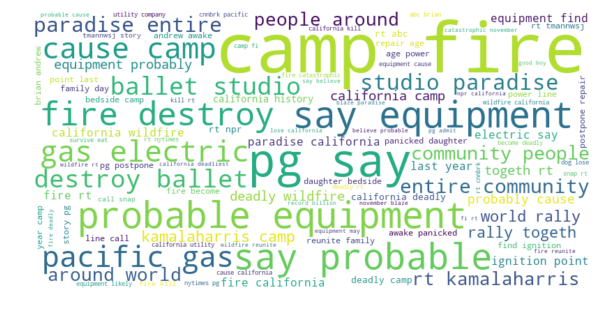

In [240]:
doc = ' '.join(cleaned_thirty_days)
wordcloud = WordCloud(width = 800, 
                      height = 400, 
                      max_font_size = 100,
                      max_words = 100,
                     background_color = "white").generate(doc)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

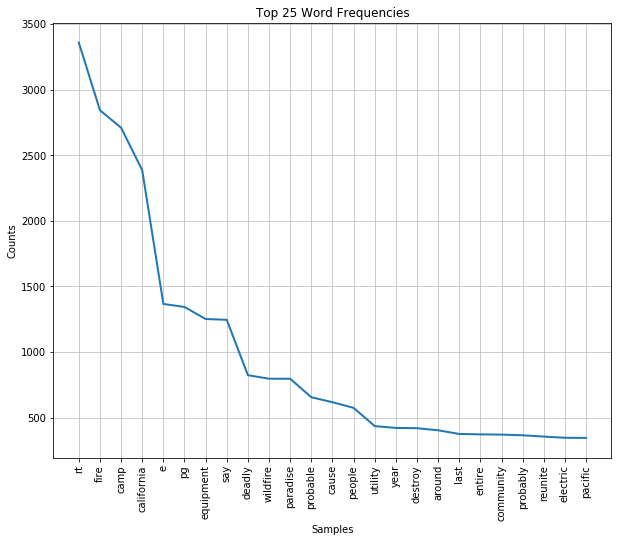

In [248]:
fq = nltk.FreqDist(w for w in cleaned_thirty_days)
fq.plot(25, title = "Top 25 Word Frequencies")

In [394]:
def tokenize_and_stem(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search("[0-9:\\.`'“’(),”\-@—&;$#!/]|https|\\bamp\\b", token) is None:
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems


def tokenize_only(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if (re.search("[0-9:\\.`'“’(),”\-@—&;$#!\*\+\?_/\\\\]|https|\\bamp\\b|rt", token) is None) and re.search("[a-zA-Z]", token):
            filtered_tokens.append(token)
    return filtered_tokens

## TFIDF Matrix

In [232]:
stemmer = SnowballStemmer("english")
tfidf_vectorizer = TfidfVectorizer(tokenizer = tokenize_only, 
                                   stop_words='english', 
                                   sublinear_tf = True)
tfidf = tfidf_vectorizer.fit_transform(thirty_days_df["Text"].tolist())
tfidf

<4794x3241 sparse matrix of type '<class 'numpy.float64'>'
	with 51125 stored elements in Compressed Sparse Row format>

In [233]:
#Get the consine similarity
dist = 1 - cosine_similarity(tfidf)
dist

array([[-2.22044605e-16,  9.11606564e-01,  8.95509850e-01, ...,
         9.92073613e-01,  9.91033904e-01,  9.91154934e-01],
       [ 9.11606564e-01,  0.00000000e+00,  3.40572227e-01, ...,
         9.95563988e-01,  9.89140503e-01,  9.95049849e-01],
       [ 8.95509850e-01,  3.40572227e-01,  0.00000000e+00, ...,
         9.94756177e-01,  9.87162955e-01,  9.94148411e-01],
       ...,
       [ 9.92073613e-01,  9.95563988e-01,  9.94756177e-01, ...,
         0.00000000e+00,  9.95636878e-01,  9.95695774e-01],
       [ 9.91033904e-01,  9.89140503e-01,  9.87162955e-01, ...,
         9.95636878e-01, -2.22044605e-16,  9.95131187e-01],
       [ 9.91154934e-01,  9.95049849e-01,  9.94148411e-01, ...,
         9.95695774e-01,  9.95131187e-01,  0.00000000e+00]])

In [234]:
tfidf_vectorizer.get_feature_names()

['abbia',
 'abc',
 'abcactionnews',
 'abcworldnews',
 'abnormal',
 'absolutely',
 'abv',
 'ab…',
 'academy',
 'academy…',
 'accelerated',
 'accepts',
 'access',
 'accfb',
 'accommodate',
 'according',
 'according…',
 'accusing',
 'acknowledged',
 'acknowledged…',
 'acknowledges',
 'acknowledge…',
 'acknowledg…',
 'acknow…',
 'ackno…',
 'acquaintances…',
 'acres',
 'acrid',
 'action',
 'active',
 'actual',
 'adamlevine',
 'adaptation',
 'add',
 'added',
 'additional',
 'address',
 'addressed',
 'admission',
 'admit',
 'admits',
 'admitted',
 'admitting',
 'admit…',
 'adoption',
 'adorns',
 'adrian',
 'adviseagainstit',
 'affai…',
 'affected',
 'affects',
 'afford',
 'afghan',
 'aftermath',
 'afterward',
 'after…',
 'afte…',
 'against…',
 'agencies',
 'agency',
 'aging',
 'ago',
 'ahora',
 'aid',
 'aide',
 'air',
 'aire',
 'akchangtwit',
 'akita',
 'al',
 'alabama',
 'alarm',
 'alastairgee',
 'album',
 'alexcessive',
 'alexckaufman',
 'alfredgockel',
 'algal',
 'alive',
 'alle',
 'allege

## Categorizing Tweet Data Frame

In [299]:
ids = ['Tweet {0}'.format(i) for i in thirty_days_df.index]
#df_with_ids = thirty_days_df.set_index(pd.Series(ids).values)
df_with_ids = thirty_days_df.assign(title=pd.Series(ids).values)

df_with_ids["source"] = "Twitter"

d = {'text' : df_with_ids["Text"], 'title' : ids, 'source' : df_with_ids["source"]}
only_ids = pd.DataFrame(d)
only_ids.to_pickle("tweets_with_id.txt")


In [289]:
only_ids

,text,title,source
0,RT @cnnbrk: Pacific Gas &amp; Electric says it...,Tweet 0,Twitter
1,RT @Bewickwren: California Wildfires On The Sc...,Tweet 1,Twitter
2,California Wildfires On The Scale Of Camp Fire...,Tweet 2,Twitter
3,California Wildfires On The Scale Of Camp Fire...,Tweet 3,Twitter
4,California Wildfires On The Scale Of Camp Fire...,Tweet 4,Twitter
5,RT @AnimalBandon: This is what we just sent to...,Tweet 5,Twitter
6,RT @cnnbrk: Pacific Gas &amp; Electric says it...,Tweet 6,Twitter
7,PG&amp;E is risky but I am saying to buy it so...,Tweet 7,Twitter
8,RT @cnnbrk: Pacific Gas &amp; Electric says it...,Tweet 8,Twitter
9,RT @usatodayvideo: A dog returns home 101 days...,Tweet 9,Twitter
